# Galaxies vs quasars with neural networks

In [1]:
import numpy as np
import pylab as plt
import scipy.stats
import pandas as pd
import seaborn as sns
import os

from sklearn import preprocessing
from astroML.utils import split_samples
from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow import keras
import keras_tuner
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc

plt.style.use('seaborn-v0_8-deep')
plt.rc('text', usetex=True)  
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
np.random.seed(42)

In [3]:
input_file_path = '/Users/giulia/coding/astrostat/astrostatistics_bicocca_2024/solutions/galaxyquasar.csv'

data = pd.read_csv(input_file_path)
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [4]:
u_g = data['u'] - data['g']
g_r = data['g'] - data['r']
r_i = data['r'] - data['i']
i_z = data['i'] - data['z']

X0 = np.array([u_g,g_r,r_i,i_z]).T

In [5]:
class_to_number = {"GALAXY": 0, "QSO": 1}  # mapping
labels = np.array([class_to_number[cl] for cl in data['class']]) # convert the string array to an array of 0/1

y=labels

Scale the data

In [6]:
X = preprocessing.scale(X0)

Divide in train and test set

In [7]:
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=0)

### Build the neural network

In [8]:
def trainnetwork(X_train, X_test, y_train, y_test, filename='trained_model.keras'):
    history = None
    
    if not os.path.isfile(filename):
        
        train_in = X_train
        train_out = y_train
        test_in = X_test
        test_out = y_test
        
        # Kernel initializer
        my_init = keras.initializers.glorot_uniform(seed=1)

        # Architecture
        model = keras.Sequential([
            
            # Input layer
            tf.keras.layers.InputLayer(shape=np.shape(train_in[0])),
            
            # Hidden layer with ReLU activation
            keras.layers.Dense(5, activation='relu', kernel_initializer=my_init),
            
            # Output layer
            keras.layers.Dense(1, activation='sigmoid', kernel_initializer=my_init)
        ])

        
        # Compile the model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),  # Adam solver with learning rate 0.001
            loss='binary_crossentropy',  # Loss for binary classification
            metrics=['accuracy']  # Track accuracy
        )

        # Decrease the learning rate exponentially after the first 10 epochs
        def scheduler(epoch, lr):
            if epoch < 10:
                return float(lr)
            else:
                return float(lr * tf.math.exp(-0.05))

        # Training
        history = model.fit(
            train_in, 
            train_out,
            validation_data=(test_in, test_out),
            epochs=150,
            callbacks=[
                
                # Adjust learning rate
                tf.keras.callbacks.LearningRateScheduler(scheduler),
                
                # Save the best model
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True
                ),
                tf.keras.callbacks.TensorBoard(log_dir="logs" + filename.split('.h5')[0], histogram_freq=1)
            ],
            shuffle=True,
            verbose=0  #shorter output
        )

    # Load the trained model
    model = loadnetwork(filename)
    return model


def loadnetwork(filename, verbose=False):
    #Load the trained neural network
    model = tf.keras.models.load_model(filename)
    if verbose:
        model.summary()
    return model


def testnetwork(model, X_test, y_test):
    model.evaluate(X_test, y_test, verbose=2)


def predictnetwork(model, X_test):
    predictions = np.squeeze((model.predict(X_test) > 0.5).astype("int32"))
    return predictions


def plot_roc_curve(model, X_test, y_test):
    y_pred_prob = model.predict(X_test).ravel()
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.xlim(0,0.1)
    plt.ylim(0.9,1)
    plt.show()


### Train and test the neural network

In [9]:
model = trainnetwork(X_train, X_test, y_train, y_test)

In [10]:
testnetwork(model, X_test, y_test)

391/391 - 0s - 652us/step - accuracy: 0.9832 - loss: 0.0687


In [11]:
predictions = predictnetwork(model, X_test)

391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 222us/step


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step


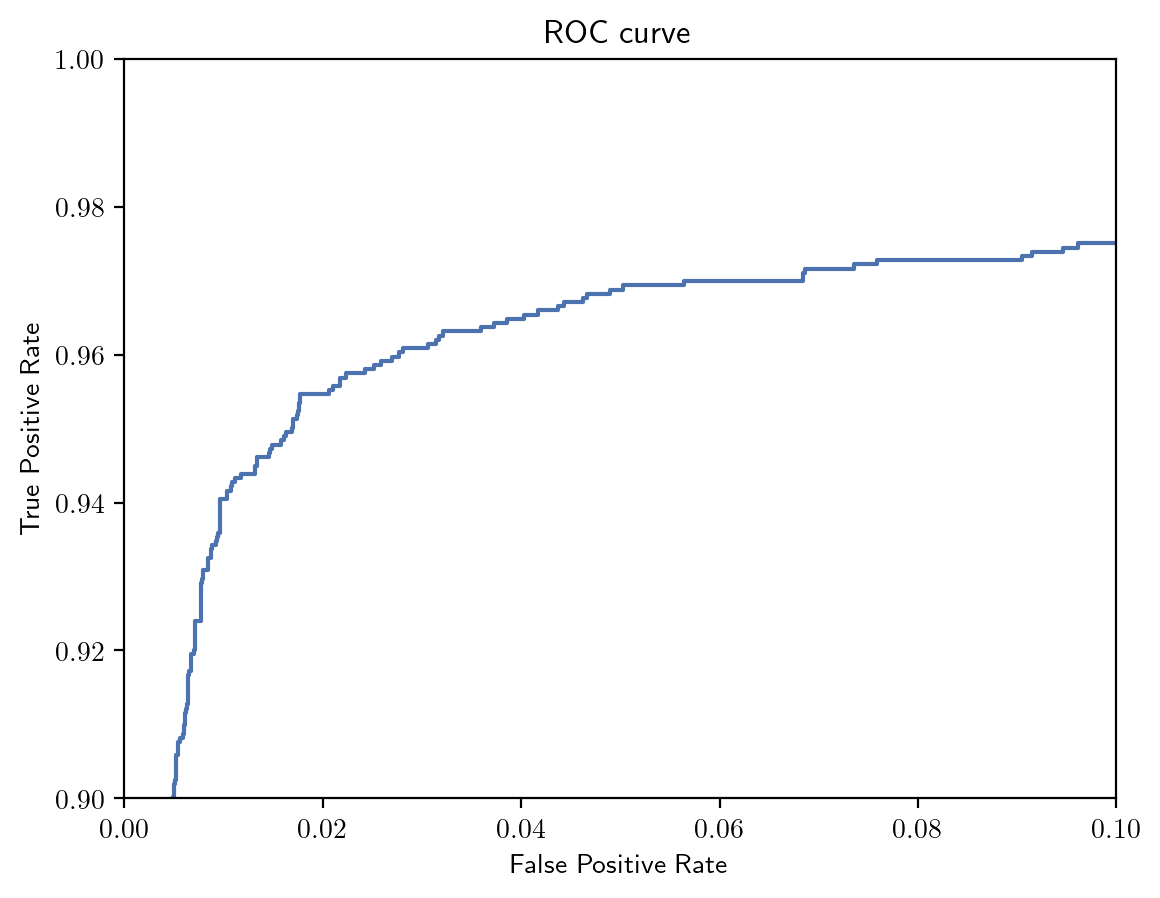

In [12]:
plot_roc_curve(model, X_test, y_test)

### Optimize the hyperparameters

In [13]:
def build_model(hp):
    model = keras.Sequential()

    num_layers = hp.Int('num_layers', min_value=1, max_value=3, step=1)  # Number of hidden layers
    
    for i in range(num_layers):
        units = hp.Choice(f'units_{i}', [5, 10, 15, 20, 25])
        activation = 'relu'
        model.add(keras.layers.Dense(units, activation=activation))
    
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
    
    model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),  # Adam solver with given learning rate
            loss='binary_crossentropy',  # Loss for binary classification
            metrics=['accuracy']  # Track accuracy
    )
    
    return model


# Tuner configuration
tuner = keras_tuner.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory="/tmp/tb",
    overwrite=True,
)
                     

tuner.search(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=50,
    # Use the TensorBoard callback.
    # The logs will be write to "/tmp/tb_logs".
    callbacks=[keras.callbacks.TensorBoard("/tmp/tb_logs")],
)



best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""


The hyperparameter search is complete. 

Optimal parameters:
- Number of layers is: {best_hps.get('num_layers')}

""")

for i in range(best_hps.get('num_layers')):
    neurons_in_i = best_hps.get(f'units_{i}')
    print(f'- Number of neurons in the FIRST layer is: {neurons_in_i}')
#- Number of neurons in the SECOND layer is: {best_hps.get('units_1')} 
#- Number of neurons in the THIRD layer is: {best_hps.get('units_2')} 

print(f"""

- Learning rate for the optimizer is: {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 00m 06s]
val_accuracy: 0.9858666658401489

Best val_accuracy So Far: 0.9874666929244995
Total elapsed time: 00h 01m 25s



The hyperparameter search is complete. 

Optimal parameters:
- Number of layers is: 3


- Number of neurons in the FIRST layer is: 20
- Number of neurons in the FIRST layer is: 20
- Number of neurons in the FIRST layer is: 15


- Learning rate for the optimizer is: 0.01.



NB: Keras Tuner provides four available tuners: RandomSearch, Hyperband, BayesianOptimization, and Sklearn.

Here I used Hyperband, which is particularly efficient because it progressively eliminates underperforming configurations. It ensures that computational resources are concentrated on hyperparameter combinations with the most potential, reducing the overall training cost.

### Build my NN with optimized hyperparameters

In [14]:
def trainnetwork(X_train, X_test, y_train, y_test, filename='trained_optimized_model.keras'):
    history = None
    
    if not os.path.isfile(filename):
        
        train_in = X_train
        train_out = y_train
        test_in = X_test
        test_out = y_test
        
        # Kernel initializer
        my_init = keras.initializers.glorot_uniform(seed=1)
        
        # Architecture
        model = keras.Sequential([
            # Input layer
            tf.keras.layers.InputLayer(shape=np.shape(train_in[0])),
            ])
            
        # Hidden layers with ReLU activation
        for i in range(best_hps.get('num_layers')):
            units = best_hps.get(f'units_{i}')
            activation = 'relu'
            model.add(keras.layers.Dense(units, activation=activation))
    
        # Output layer
        model.add(keras.layers.Dense(1, activation='sigmoid'))
        
        # Compile the model
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),  # Adam solver with optimized learning rate
            loss='binary_crossentropy',  # Loss for binary classification
            metrics=['accuracy']  # Track accuracy
        )

        # Decrease the learning rate exponentially after the first 10 epochs
        def scheduler(epoch, lr):
            if epoch < 10:
                return float(lr)
            else:
                return float(lr * tf.math.exp(-0.05))

        # Training
        history = model.fit(
            train_in, 
            train_out,
            validation_data=(test_in, test_out),
            epochs=250,
            callbacks=[
                
                # Adjust learning rate
                tf.keras.callbacks.LearningRateScheduler(scheduler),
                
                # Save the best model
                tf.keras.callbacks.ModelCheckpoint(
                    filepath=filename,
                    save_weights_only=False,
                    monitor='val_accuracy',
                    mode='max',
                    save_best_only=True
                ),
                tf.keras.callbacks.TensorBoard(log_dir="logs" + filename.split('.h5')[0], histogram_freq=1)
            ],
            shuffle=True,
            verbose=0  #shorter output
        )

    # Load the trained model
    model = loadnetwork(filename)
    return model


def loadnetwork(filename, verbose=False):
    #Load the trained neural network.
    model = tf.keras.models.load_model(filename)
    if verbose:
        model.summary()
    return model


def testnetwork(model, X_test, y_test):
    model.evaluate(X_test, y_test, verbose=2)


def predictnetwork(model, X_test):
    predictions = np.squeeze((model.predict(X_test) > 0.5).astype("int32"))
    return predictions


def plot_roc_curve(model, X_test, y_test):
    y_pred_prob = model.predict(X_test).ravel()
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC curve")
    plt.xlim(0,0.1)
    plt.ylim(0.9,1)
    plt.show()


In [15]:
model = trainnetwork(X_train, X_test, y_train, y_test)

In [16]:
result = testnetwork(model, X_test, y_test)

391/391 - 0s - 519us/step - accuracy: 0.9871 - loss: 0.0491


In [17]:
predictions = predictnetwork(model, X_test)

391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 233us/step


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 205us/step


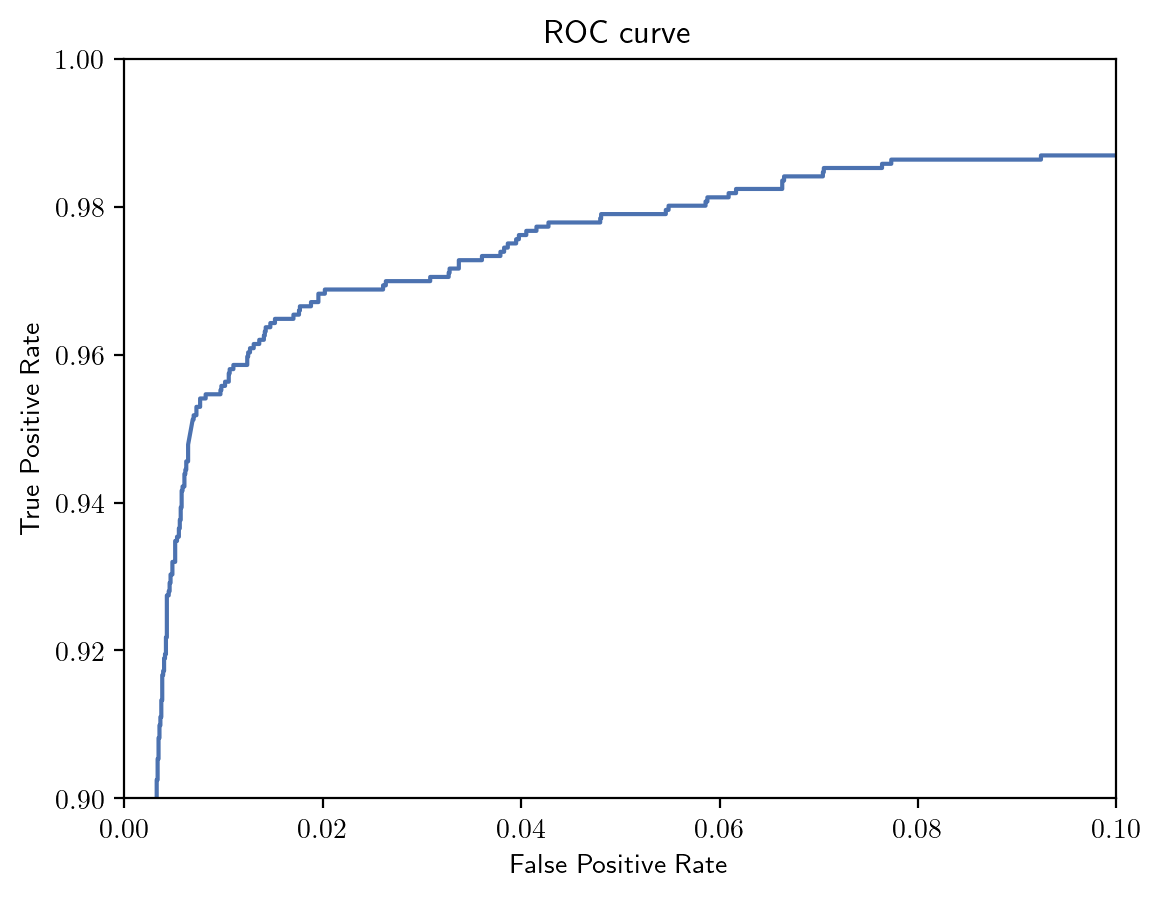

In [18]:
plot_roc_curve(model, X_test, y_test)

# RandomForestClassifier

In [20]:
rf = RandomForestClassifier(random_state=42, n_estimators=100)

rf.fit(X_train, y_train)

rf_train_accuracy = rf.score(X_train, y_train)
rf_test_accuracy = rf.score(X_test, y_test)

print(f"RandomForest Test Accuracy: {rf_test_accuracy:.4f}")

RandomForest Test Accuracy: 0.9867


The value of accuracy is comparable with the one of the neural network. I don't need a NN to solve this problem.